## SIIM 比赛介绍
![img](./siim.png)

> 皮肤癌是最普遍的癌症类型。尽管是最不常见的皮肤癌，但黑色素瘤仍可导致75％的皮肤癌死亡。美国癌症协会估计，到2020年将诊断出100,000多例新的黑色素瘤病例。还预计将有7,000人死于这种疾病。与其他癌症一样，在数据科学的帮助下进行早期而准确的检测可以使治疗更加有效。
当前，皮肤科医生评估患者的每一颗痣，以找出最有可能是黑色素瘤的异常病灶或“丑小鸭”。现有的AI方法尚未充分考虑此临床参考框架。如果检测算法考虑到同一患者内的“上下文”图像以确定哪些图像代表黑色素瘤，则皮肤科医生可以提高诊断准确性。如果成功，分类器将更加准确，并且可以更好地支持皮肤科临床工作。
作为医学影像学信息学的领先医疗保健组织，医学影像学信息学协会（SIIM）的使命是通过多学科社区中的教育，研究和创新来推进医学影像学信息学。SIIM加入了国际皮肤影像协作组织（ISIC），这是一项国际努力，旨在改善黑色素瘤的诊断。ISIC档案库包含最大数量的公众可获得的皮肤损伤的经皮肤镜检查的质量控制图像。
在这场比赛中，您将在皮肤病变图像中识别黑色素瘤。特别是，您将使用同一位患者的图像，并确定哪些图像可能代表黑色素瘤。使用患者级别的上下文信息可能有助于图像分析工具的开发，从而可以更好地支持临床皮肤科医生。
黑色素瘤是一种致命的疾病，但是如果尽早发现，大多数黑色素瘤可以通过较小的手术治愈。自动诊断黑色素瘤的图像分析工具将提高皮肤科医生的诊断准确性。更好地发现黑色素瘤有机会对数百万人产生积极影响。

## 1.下载efficientnet预训练的包

In [1]:
!pip install -q efficientnet
!pip install -q git+https://github.com/AmedeoBiolatti/dsqol

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## 2.导入相应的包

In [2]:
import os, re, time, tqdm,math,random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics, model_selection

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras 
from tensorflow.keras import backend as K
from efficientnet import tfkeras as efnet

from kaggle_datasets import KaggleDatasets

In [3]:
# my github for trivial but useful functions
from dsqol.tf import imgaug
from dsqol.tf.data import balance
from dsqol.tf.utils import average
from dsqol.tf import losses

## 3.参数配置

In [4]:

# 设置种子，方便代码复现
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

TIME_BUDGET = 2.5 * 3600 # time budget allocated for the training (Kaggle has 3 hours max time)

# 6折KFOLD

FOLDS = 6
INCLUDE_2019 = 0
INCLUDE_2018 = 1
INCLUDE_MALIGNANT = 1

# 图片尺寸
IMG_READ_SIZE     = 384
IMG_SIZE          = 384
BALANCE_POS_RATIO = 0.08

# 模型参数
EFF_NET      = 6 ### 6代表是efficient6的网络
# loss and loss params
LOSS_TYPE    = 'BCE' # 'BCE', 'FOCAL'  ## BCE是二元交叉商损失，另一个是focal loss
LOSS_PARAMS  = dict(label_smoothing=0.09) ### 使用label smoothing，https://blog.csdn.net/qq_43211132/article/details/100510113

# 训练参数
BATCH_SIZE  = 64
EPOCHS      = 25
# lr schedule

# 其他参数
TBM        = 6
TTA        = 15
VALID_FREQ = 1
N_SWA      = 3
SWA_DECAY  = 0.9

In [5]:
### 在kaggle平台上可以使用TPU或者GPU来跑代码，根据DECVICE的设置来选择哪一个进行加速
DEVICE = "TPU"
print("connecting to TPU...")
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    print("Could not connect to TPU")
    tpu = None
if tpu:
    try:
        print("initializing  TPU ...")
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("TPU initialized")
    except _:
        print("failed to initialize TPU")
else:
    DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    
AUTO              = tf.data.experimental.AUTOTUNE
REPLICAS          = strategy.num_replicas_in_sync
GLOBAL_BATCH_SIZE = BATCH_SIZE * REPLICAS
print("REPLICAS: %d" % REPLICAS)

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


## 4.数据预处理

https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/169139

### 读取数据，包括2018年，2019年的

In [6]:
GCS_PATH1 = KaggleDatasets().get_gcs_path('melanoma-%ix%i' % (IMG_READ_SIZE, IMG_READ_SIZE))
GCS_PATH2 = KaggleDatasets().get_gcs_path('isic2019-%ix%i' % (IMG_READ_SIZE, IMG_READ_SIZE))
GCS_PATH3 = KaggleDatasets().get_gcs_path('malignant-v2-%ix%i' % (IMG_READ_SIZE, IMG_READ_SIZE))

In [7]:
df_base_train = pd.read_csv("../input/siim-isic-melanoma-classification/train.csv")
df_base_test = pd.read_csv("../input/siim-isic-melanoma-classification/test.csv")

In [8]:
train_files = tf.io.gfile.glob(os.path.join(GCS_PATH1, "train*.tfrec"))
#
if INCLUDE_2019:
    train_files += tf.io.gfile.glob([os.path.join(GCS_PATH2, "train%.2i*.tfrec" % i) for i in range(1, 30, 2)])
if INCLUDE_2018:
    train_files += tf.io.gfile.glob([os.path.join(GCS_PATH2, "train%.2i*.tfrec" % i) for i in range(0, 30, 2)])
#
if INCLUDE_MALIGNANT:
    train_files += tf.io.gfile.glob([os.path.join(GCS_PATH3, "train%.2i*.tfrec" % i) for i in range(15, 30, 1)])
print("%d train files found" % len(train_files))

45 train files found


In [9]:
test_files = tf.io.gfile.glob(os.path.join(GCS_PATH1, "test*.tfrec"))
print("%d test files found" % len(test_files))

16 test files found


In [10]:
### 读取有标签的图片，也就是训练集tfrecord数据
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        #'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        #'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        #'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        #'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        #'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']

### 读取没有标签的图片，也就是测试集tfrecord数据
def read_unlabeled_tfrecord(example, return_image_name=True):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0


### 数据预处理，除以255
def prepare_image(img):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0           
    return img

### 统计数目
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [ ]:
### 下面两个都是给grid mask 用的
def transform(image, inv_mat, image_shape):
    h, w, c = image_shape
    cx, cy = w//2, h//2
    new_xs = tf.repeat( tf.range(-cx, cx, 1), h)
    new_ys = tf.tile( tf.range(-cy, cy, 1), [w])
    new_zs = tf.ones([h*w], dtype=tf.int32)
    old_coords = tf.matmul(inv_mat, tf.cast(tf.stack([new_xs, new_ys, new_zs]), tf.float32))
    old_coords_x, old_coords_y = tf.round(old_coords[0, :] + w//2), tf.round(old_coords[1, :] + h//2)
    clip_mask_x = tf.logical_or(old_coords_x<0, old_coords_x>w-1)
    clip_mask_y = tf.logical_or(old_coords_y<0, old_coords_y>h-1)
    clip_mask = tf.logical_or(clip_mask_x, clip_mask_y)
    old_coords_x = tf.boolean_mask(old_coords_x, tf.logical_not(clip_mask))
    old_coords_y = tf.boolean_mask(old_coords_y, tf.logical_not(clip_mask))
    new_coords_x = tf.boolean_mask(new_xs+cx, tf.logical_not(clip_mask))
    new_coords_y = tf.boolean_mask(new_ys+cy, tf.logical_not(clip_mask))
    old_coords = tf.cast(tf.stack([old_coords_y, old_coords_x]), tf.int32)
    new_coords = tf.cast(tf.stack([new_coords_y, new_coords_x]), tf.int64)
    rotated_image_values = tf.gather_nd(image, tf.transpose(old_coords))
    rotated_image_channel = list()
    for i in range(c):
        vals = rotated_image_values[:,i]
        sparse_channel = tf.SparseTensor(tf.transpose(new_coords), vals, [h, w])
        rotated_image_channel.append(tf.sparse.to_dense(sparse_channel, default_value=0, validate_indices=False))
    return tf.transpose(tf.stack(rotated_image_channel), [1,2,0])

### 随机旋转函数
def random_rotate(image, angle, image_shape):
    def get_rotation_mat_inv(angle):
        # transform to radian
        angle = math.pi * angle / 180
        cos_val = tf.math.cos(angle)
        sin_val = tf.math.sin(angle)
        one = tf.constant([1], tf.float32)
        zero = tf.constant([0], tf.float32)
        rot_mat_inv = tf.concat([cos_val, sin_val, zero, -sin_val, cos_val, zero, zero, zero, one], axis=0)
        rot_mat_inv = tf.reshape(rot_mat_inv, [3,3])
        return rot_mat_inv
    angle = float(angle) * tf.random.normal([1],dtype='float32')
    rot_mat_inv = get_rotation_mat_inv(angle)
    return transform(image, rot_mat_inv, image_shape)

In [ ]:
### GridMask的代码
def GridMask(image_height, image_width, d1, d2, rotate_angle=1, ratio=0.5):
    h, w = image_height, image_width
    hh = int(np.ceil(np.sqrt(h*h+w*w)))
    hh = hh+1 if hh%2==1 else hh
    d = tf.random.uniform(shape=[], minval=d1, maxval=d2, dtype=tf.int32)
    l = tf.cast(tf.cast(d,tf.float32)*ratio+0.5, tf.int32)

    st_h = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)
    st_w = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)

    y_ranges = tf.range(-1 * d + st_h, -1 * d + st_h + l)
    x_ranges = tf.range(-1 * d + st_w, -1 * d + st_w + l)

    for i in range(0, hh//d+1):
        s1 = i * d + st_h
        s2 = i * d + st_w
        y_ranges = tf.concat([y_ranges, tf.range(s1,s1+l)], axis=0)
        x_ranges = tf.concat([x_ranges, tf.range(s2,s2+l)], axis=0)

    x_clip_mask = tf.logical_or(x_ranges < 0 , x_ranges > hh-1)
    y_clip_mask = tf.logical_or(y_ranges < 0 , y_ranges > hh-1)
    clip_mask = tf.logical_or(x_clip_mask, y_clip_mask)

    x_ranges = tf.boolean_mask(x_ranges, tf.logical_not(clip_mask))
    y_ranges = tf.boolean_mask(y_ranges, tf.logical_not(clip_mask))

    hh_ranges = tf.tile(tf.range(0,hh), [tf.cast(tf.reduce_sum(tf.ones_like(x_ranges)), tf.int32)])
    x_ranges = tf.repeat(x_ranges, hh)
    y_ranges = tf.repeat(y_ranges, hh)

    y_hh_indices = tf.transpose(tf.stack([y_ranges, hh_ranges]))
    x_hh_indices = tf.transpose(tf.stack([hh_ranges, x_ranges]))

    y_mask_sparse = tf.SparseTensor(tf.cast(y_hh_indices, tf.int64),  tf.zeros_like(y_ranges), [hh, hh])
    y_mask = tf.sparse.to_dense(y_mask_sparse, 1, False)

    x_mask_sparse = tf.SparseTensor(tf.cast(x_hh_indices, tf.int64), tf.zeros_like(x_ranges), [hh, hh])
    x_mask = tf.sparse.to_dense(x_mask_sparse, 1, False)

    mask = tf.expand_dims( tf.clip_by_value(x_mask + y_mask, 0, 1), axis=-1)

    mask = random_rotate(mask, rotate_angle, [hh, hh, 1])
    mask = tf.image.crop_to_bounding_box(mask, (hh-h)//2, (hh-w)//2, image_height, image_width)

    return mask


### GridMask的效果

![img](gridmask.png)

In [ ]:
def apply_grid_mask(image, image_shape):
    AugParams = {
        'd1' : 100,
        'd2': 160,
        'rotate' : 45,
        'ratio' : 0.3
    }
    mask = GridMask(image_shape[0], image_shape[1], AugParams['d1'], AugParams['d2'], AugParams['rotate'], AugParams['ratio'])
    if image_shape[-1] == 3:
        mask = tf.concat([mask, mask, mask], axis=-1)
    return image * tf.cast(mask,tf.float32)

def gridmask(img_batch):
    return apply_grid_mask(img_batch, (IMG_SIZE,IMG_SIZE, 3))

In [12]:
### 基础数据增强
def base_aug(img):
    img = tf.image.random_flip_left_right(img)
    #img = tf.image.random_hue(img, 0.01)
    img = tf.image.random_saturation(img, 0.8, 1.1)
    img = tf.image.random_contrast(img, 0.8, 1.1)
    img = tf.image.random_brightness(img, 0.1)
    img = gridmask(img)
    return img

transform_aug = imgaug.Transform(dim=IMG_READ_SIZE)

### 数据增强pipeline
def basic_augmentation_pipeline(ds: tf.data.Dataset, dim=None, batch_size=None) -> tf.data.Dataset:
    ds = ds.map(lambda i, o: (transform_aug(i), o), num_parallel_calls=AUTO)
    ds = ds.map(lambda i, o: (base_aug(i), o), num_parallel_calls=AUTO)
    return ds

In [13]:
### 获取数据集，到时候给tensorflow处理
def get_dataset(files, augment=False, repeat=False, shuffle=False, labeled=True, batch_size=16, drop_remainder=False, 
                dim=256, read_dim=None
               ) -> tf.data.Dataset:
    if read_dim is None:
        read_dim = dim
    ## 读取数据
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    ## 打乱数据
    if shuffle: 
        ds = ds.shuffle(1024 * 8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    
    ## 如果labeled为真，代表训练阶段
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    ## 如果labeled为假，代表测试阶段
    else:
        ds = ds.map(read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    ds = ds.map(lambda i, o: (prepare_image(i), o), num_parallel_calls=AUTO)

    ## 数据增强
    if augment:
        ds = basic_augmentation_pipeline(ds, batch_size=8 * batch_size, dim=read_dim) 
        if isinstance(augment, list):
            for a in augment:
                ds = ds.map(a, num_parallel_calls=AUTO)
        
    ds = ds.map(lambda i, o: (tf.image.resize(i, [dim, dim]), o), num_parallel_calls=AUTO)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.prefetch(AUTO)
    return ds

### 把数据平衡一下，因为有癌症的图片个数比较少，没有癌症的图片比较多，平衡一下比例，进行下下采样
### 对get_dataset这个函数进行微调了一下
def get_balanced_dataset(files, augment=False, repeat=False, shuffle=False, batch_size=16, drop_remainder=False, 
                         dim=256, read_dim=None, pos_ratio=False) -> tf.data.Dataset:
    if read_dim is None:
        read_dim = dim
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
        
    ds0, ds1 = balance.separate_by_target(ds)
    ds0 = ds.map(lambda i, o: (prepare_image(i), o), num_parallel_calls=AUTO)
    ds1 = ds.map(lambda i, o: (prepare_image(i), o), num_parallel_calls=AUTO)
    ds = balance.merge_ds(ds0, ds1, pos_ratio)
    if shuffle: 
        ds = ds.shuffle(1024)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    
    if augment:
        ds = basic_augmentation_pipeline(ds, batch_size=8 * batch_size, dim=read_dim) 
        if isinstance(augment, list):
            for a in augment:
                ds = ds.map(a, num_parallel_calls=AUTO)
    ds = ds.map(lambda i, o: (tf.image.resize(i, [dim, dim]), o), num_parallel_calls=AUTO)
        
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.prefetch(AUTO)
    return ds

## 5.模型搭建

In [14]:
def build_model(dim=128, ef=0):
    ### 输入图像
    inp = keras.layers.Input(shape=(dim,dim,3))
    ### 基模型
    base = getattr(efnet, 'EfficientNetB%d' % ef)(input_shape=(dim, dim, 3), weights='imagenet', include_top=False)
    x = base(inp)
    ### 全局平均池化
    x = keras.layers.GlobalAveragePooling2D()(x)
    ### 后面几层全连接
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(512)(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(256)(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(128)(x)
    
     ### 最后一层只有一个神经元，因为是二分类问题
    x = keras.layers.Dense(1)(x)
    x = keras.layers.Activation('sigmoid', dtype='float32')(x)
    model = keras.Model(inputs=inp,outputs=x)
    opt = keras.optimizers.Adam(learning_rate=1e-3)
    if LOSS_TYPE.upper() == 'BCE':
        loss = keras.losses.BinaryCrossentropy(**LOSS_PARAMS)
    elif LOSS_TYPE.upper() == 'FOCAL':
        loss = losses.BinaryFocalLoss(**LOSS_PARAMS)
    model.compile(optimizer=opt, loss=loss, metrics=['AUC'])
    return model

## 6.学习率曲线

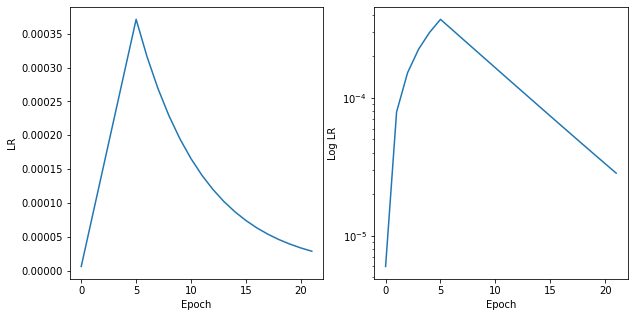

In [15]:
### 学习率设置，前5个epoch学习率变高，后面对数下降
mult       = 1
lr_start   = 6e-6
lr_max     = 1.45e-6 * GLOBAL_BATCH_SIZE
lr_min     = 1e-6
lr_ramp_ep = 5
lr_sus_ep  = 0
lr_decay   = 0.85


def lrfn(epoch):
    if epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max
    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
    return lr * mult
    

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot([lrfn(e) for e in range(EPOCHS)])
plt.xlabel('Epoch'); plt.ylabel('LR')
plt.subplot(1, 2, 2)
plt.plot([lrfn(e) for e in range(EPOCHS)])
plt.xlabel('Epoch'); plt.ylabel('Log LR')
plt.yscale('log');

## 一些设置

In [3]:
# 保存成CKPT的地址
CKPT_FOLDER = "../working/ckpt"
if not os.path.exists(CKPT_FOLDER):
    os.mkdir(CKPT_FOLDER)
# KFold
folds = list(model_selection.KFold(n_splits=FOLDS, shuffle=True, random_state=SEED).split(np.arange(15)))
testiness = pd.read_csv("../input/spicv-spicy-vi-make-your-cv-more-testy/testiness.csv")
# 正样本设置
TOTAL_POS = 581 + 2858 * INCLUDE_2019 + 1651 * INCLUDE_2018 + 580 * INCLUDE_MALIGNANT

NameError: name 'os' is not defined

####################################################################
####################		Fold 0		####################
####################################################################
Train files: 42		 Valid files: 3
165527552/165527152 [==============================] - 2s 0us/step
Using balanced dataset with pos_ratio = 8%
Training...
Epoch 1/22
114/114 [==============================] - 121s 1s/step - loss: 0.5731 - auc: 0.6160 - val_loss: 0.3602 - val_auc: 0.6593 - lr: 6.0000e-06
Epoch 2/22
114/114 [==============================] - 79s 689ms/step - loss: 0.3045 - auc: 0.7828 - val_loss: 0.1716 - val_auc: 0.8087 - lr: 7.9040e-05
Epoch 3/22
114/114 [==============================] - 78s 688ms/step - loss: 0.2304 - auc: 0.8433 - val_loss: 0.1873 - val_auc: 0.8412 - lr: 1.5208e-04
Epoch 4/22
114/114 [==============================] - 78s 686ms/step - loss: 0.2712 - auc: 0.8799 - val_loss: 0.1696 - val_auc: 0.8251 - lr: 2.2512e-04
Epoch 5/22
114/114 [==============================

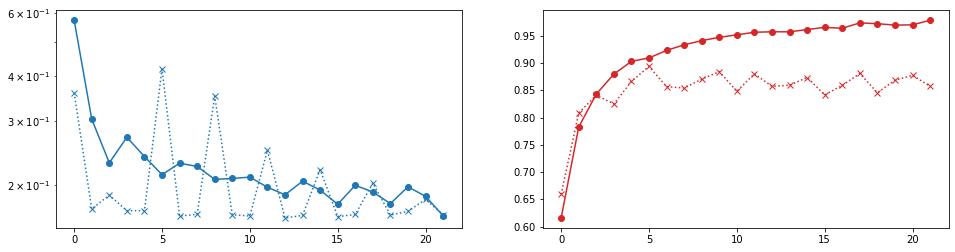




####################################################################
####################		Fold 1		####################
####################################################################
Train files: 42		 Valid files: 3
Using balanced dataset with pos_ratio = 8%
Training...
Epoch 1/22
114/114 [==============================] - 115s 1s/step - loss: 0.5796 - auc: 0.6036 - val_loss: 0.2847 - val_auc: 0.6429 - lr: 6.0000e-06
Epoch 2/22
114/114 [==============================] - 78s 682ms/step - loss: 0.3132 - auc: 0.7655 - val_loss: 0.1728 - val_auc: 0.7713 - lr: 7.9040e-05
Epoch 3/22
114/114 [==============================] - 77s 676ms/step - loss: 0.2464 - auc: 0.8627 - val_loss: 0.2449 - val_auc: 0.8081 - lr: 1.5208e-04
Epoch 4/22
114/114 [==============================] - 77s 679ms/step - loss: 0.2726 - auc: 0.8514 - val_loss: 0.1793 - val_auc: 0.8193 - lr: 2.2512e-04
Epoch 5/22
114/114 [==============================] - 82s 721ms/step - loss: 0.2544 - auc: 0.8806 - val_loss: 0.17

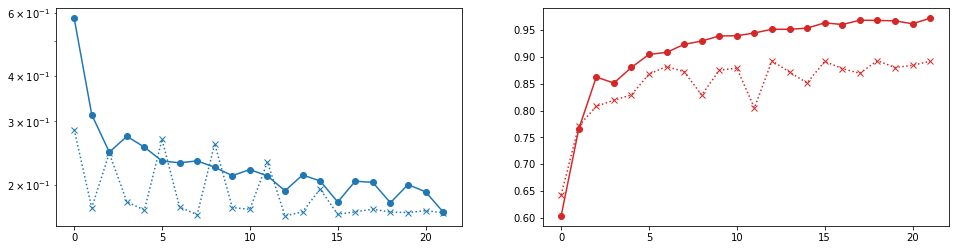




####################################################################
####################		Fold 2		####################
####################################################################
Train files: 42		 Valid files: 3
Using balanced dataset with pos_ratio = 8%
Training...
Epoch 1/22
114/114 [==============================] - 115s 1s/step - loss: 0.5745 - auc: 0.6028 - val_loss: 0.3194 - val_auc: 0.7556 - lr: 6.0000e-06
Epoch 2/22
114/114 [==============================] - 77s 679ms/step - loss: 0.3120 - auc: 0.7590 - val_loss: 0.1693 - val_auc: 0.8330 - lr: 7.9040e-05
Epoch 3/22
114/114 [==============================] - 77s 674ms/step - loss: 0.2480 - auc: 0.8576 - val_loss: 0.3016 - val_auc: 0.8674 - lr: 1.5208e-04
Epoch 4/22
114/114 [==============================] - 77s 675ms/step - loss: 0.2704 - auc: 0.8550 - val_loss: 0.1686 - val_auc: 0.8512 - lr: 2.2512e-04
Epoch 5/22
114/114 [==============================] - 78s 681ms/step - loss: 0.2511 - auc: 0.8811 - val_loss: 0.16

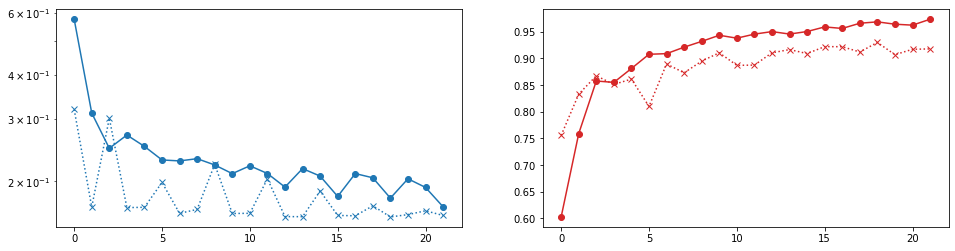




Forecasted total time till next fold completion = 10059 (budget = 9000)


In [17]:
VERBOSE = 1
PLOT    = 1

histories = []
df_oof = pd.DataFrame(); df_res = pd.DataFrame()
t_start = time.time()
for fold, (idTrain, idValid) in enumerate(folds):
    print("#" * 68)
    print(("#" * 20 + "\t\tFold %d\t\t" + "#" * 20) % fold)
    print("#" * 68)
    # TPU设置
    if DEVICE == 'TPU':
        if tpu: 
            tf.tpu.experimental.initialize_tpu_system(tpu)
    # 训练和测试集分割
    fold_valid_files = [f for f in train_files if any([int(re.match("^train([0-9]+)", f.split("/")[-1]).group(1)) % 15 == i for i in idValid])]
    fold_valid_files = [f for f in fold_valid_files if GCS_PATH1 in f] # only data from the original dataset
    # fold_train_files = [f for f in train_files if any([int(re.match("^train([0-9]+)", f.split("/")[-1]).group(1)) % 15 == i for i in idTrain])]
    fold_train_files = [f for f in train_files if f not in fold_valid_files]
    np.random.shuffle(fold_train_files)
    
    print("Train files: %d\t\t Valid files: %d" % (len(fold_train_files), len(fold_valid_files)))
    # 搭建模型，设置混合精度
    
    K.clear_session()   
    if DEVICE == 'TPU':
        keras.mixed_precision.experimental.set_policy('mixed_bfloat16')
    with strategy.scope():
        model = build_model(dim=IMG_SIZE, ef=EFF_NET)
        
    # 设置callbacks回调函数
    FOLD_CKPT_FOLDER = os.path.join(CKPT_FOLDER, "fold%d" % fold)
    if not os.path.exists(FOLD_CKPT_FOLDER):
        os.mkdir(FOLD_CKPT_FOLDER)
    callbacks =[
        keras.callbacks.ModelCheckpoint(os.path.join(FOLD_CKPT_FOLDER, "model_fold%d_e{epoch:02d}.h5" % fold), save_weights_only=True),
        keras.callbacks.LearningRateScheduler(lrfn)
    ]    
    # 如果设置平衡样本，则运行下面代码
    if BALANCE_POS_RATIO:
        print("Using balanced dataset with pos_ratio = %d%%" % int(100 * BALANCE_POS_RATIO))
        ds_train = get_balanced_dataset(fold_train_files, repeat=True,  augment=True,  drop_remainder=True,  shuffle=True,  
                                        pos_ratio=BALANCE_POS_RATIO,
                                        dim=IMG_SIZE, read_dim=IMG_READ_SIZE, batch_size=GLOBAL_BATCH_SIZE)
        FOLD_POS = TOTAL_POS * (FOLDS - 1) / FOLDS
        STEPS = int(FOLD_POS / BALANCE_POS_RATIO / GLOBAL_BATCH_SIZE)
    else:
        print("Using unbalanced dataset")
        ds_train = get_dataset(fold_train_files, repeat=True,  augment=[dropout_aug],  drop_remainder=True,  shuffle=True,  
                               dim=IMG_SIZE, read_dim=IMG_READ_SIZE, batch_size=GLOBAL_BATCH_SIZE)
        STEPS = int(count_data_items(fold_train_files) / GLOBAL_BATCH_SIZE)
    ds_valid = get_dataset(fold_valid_files, repeat=False, augment=False, drop_remainder=False, shuffle=False, 
                           dim=IMG_SIZE, read_dim=IMG_READ_SIZE, batch_size=GLOBAL_BATCH_SIZE * TBM)
    # 拟合模型
    print("Training...")
    history = model.fit(
                            ds_train,
        validation_data   = ds_valid,
        epochs            = EPOCHS,
        steps_per_epoch   = STEPS,
        verbose           = VERBOSE,
        callbacks         = callbacks,
        validation_freq   = VALID_FREQ
    )
    histories.append(history)    
    
    # SWA，将模型进行SWA加权平均，提高效果
    ckpt_files = np.sort(tf.io.gfile.glob(os.path.join(FOLD_CKPT_FOLDER, "*.h5")))
    ckpt_files_fow_swa = ckpt_files[-N_SWA:]
    if len(ckpt_files_fow_swa) > 1:
        with strategy.scope():
            model = average.average_weights(ckpt_files_fow_swa, decay=SWA_DECAY, model=model)
    for f in ckpt_files:
        os.remove(f)
    model.save(os.path.join(CKPT_FOLDER, "model_fold%d.h5" % fold))
    
    # 在验证集上验证，查看模型训练效果
    ds_valid = get_dataset(fold_valid_files, augment=TTA >= 1, repeat=True, dim=IMG_SIZE, read_dim=IMG_READ_SIZE, batch_size=GLOBAL_BATCH_SIZE * TBM, drop_remainder=True)
    ct_valid = count_data_items(fold_valid_files); STEPS = int(np.ceil(TTA * ct_valid / GLOBAL_BATCH_SIZE / TBM))
    fold_valid_pred = model.predict(ds_valid, steps=STEPS, verbose=1)
    fold_valid_pred = fold_valid_pred[:ct_valid * TTA,]
    ds_valid = get_dataset(fold_valid_files, augment=False, repeat=False, dim=IMG_SIZE, batch_size=GLOBAL_BATCH_SIZE * TBM, drop_remainder=False, labeled=False)
    fold_valid_names = np.concatenate([np.array([ni.decode("utf-8") for ni in n.numpy()]) for n in ds_valid.map(lambda i, n: n)], 0)
    
    fold_df = pd.DataFrame({'image_name': np.tile(fold_valid_names, [TTA]), 'pred': fold_valid_pred.squeeze(), 'fold': fold})
    df_oof = pd.concat([df_oof, fold_df])
    fold_df['image_name'] = fold_df['image_name'].str.replace('_downsampled', '')
    fold_df = fold_df.groupby('image_name').mean().reset_index()
    fold_df = fold_df.merge(df_base_train[['image_name', 'patient_id', 'target']], on='image_name').merge(testiness, on='image_name')
    fold_df['fold'] = fold
    auc  = metrics.roc_auc_score(fold_df.target, fold_df.pred)
    
    # 在测试集上预测
    ds_test = get_dataset(test_files, augment=TTA >= 1, repeat=True, dim=IMG_SIZE, read_dim=IMG_READ_SIZE, batch_size=GLOBAL_BATCH_SIZE * TBM, drop_remainder=True, labeled=False)
    ct_test = count_data_items(test_files); STEPS = int(np.ceil(TTA * ct_test / GLOBAL_BATCH_SIZE / TBM))
    fold_test_pred = model.predict(ds_test.map(lambda i, l: i), steps=STEPS, verbose=1)
    fold_test_pred = fold_test_pred[:ct_test * TTA,]
    ds_test = get_dataset(test_files, augment=False, repeat=False, dim=IMG_SIZE, batch_size=GLOBAL_BATCH_SIZE * TBM, drop_remainder=False, labeled=False)
    fold_test_names = np.concatenate([np.array([ni.decode("utf-8") for ni in n.numpy()]) for n in ds_test.map(lambda i, n: n)], 0)
    
    fold_res = pd.DataFrame({'image_name': np.tile(fold_test_names, [TTA]), 'pred': fold_test_pred.squeeze(), 'fold': fold})
    df_res = pd.concat([df_res, fold_res])
    
    # 画出一些统计的曲线，以及相关参数
    used_time_till_now = time.time() - t_start
    time_per_fold = used_time_till_now / (fold + 1)
    print("Validation AUC last epoch = %.4f" % history.history['val_auc'][-1])
    print("Validation AUC  (TTA %2d) = %.4f" % (TTA, auc))
    print("Total time = %ds\t\tTime per fold = %ds" % (int(used_time_till_now), int(time_per_fold)))
    
    # plot
    if PLOT:
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], color='tab:blue', marker='o')
        plt.plot(range(VALID_FREQ - 1, EPOCHS, VALID_FREQ), history.history['val_loss'], color='tab:blue', marker='x', linestyle=':')
        plt.yscale('log')
        plt.subplot(1, 2, 2)
        plt.plot(history.history['auc'], color='tab:red', marker='o')
        plt.plot(range(VALID_FREQ - 1, EPOCHS, VALID_FREQ), history.history['val_auc'], color='tab:red', marker='x', linestyle=':')
        plt.show()
    
    del model, ds_train, ds_valid, ds_test
    print("\n\n")
    
    if (fold + 1) < FOLDS:
        # time: if next iteration will exceed the time budget, abort
        time_till_next_fold = used_time_till_now + time_per_fold
        if time_till_next_fold > TIME_BUDGET:
            print("Forecasted total time till next fold completion = %d (budget = %d)" % (time_till_next_fold, TIME_BUDGET))
            break
    pass

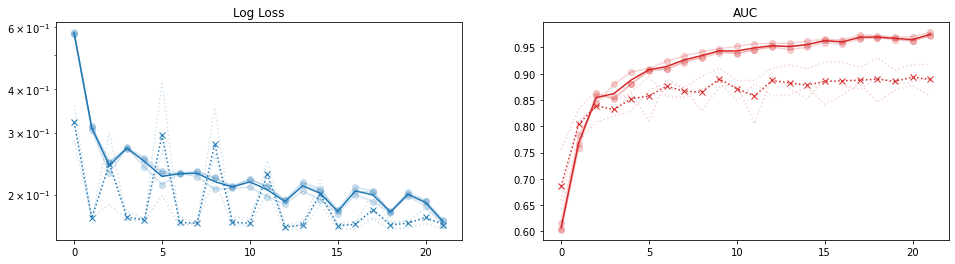

In [18]:
### 画出损失函数，和AUC曲线
avgh = dict()
for history in histories:
    for k in history.history.keys():
        if k in avgh.keys():
            avgh[k] = np.concatenate([avgh[k], np.array(history.history[k]).reshape(-1, 1)], 1)
        else:
            avgh[k] = np.array(history.history[k]).reshape(-1, 1)
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.title('Log Loss')
plt.plot(avgh['loss'], marker='o', color='tab:blue', alpha=0.2)
plt.plot(avgh['loss'].mean(1), color='tab:blue')
plt.plot(range(VALID_FREQ - 1, EPOCHS, VALID_FREQ), avgh['val_loss'], color='tab:blue', alpha=0.2, linestyle=":")
plt.plot(range(VALID_FREQ - 1, EPOCHS, VALID_FREQ), avgh['val_loss'].mean(1), marker='x', color='tab:blue', linestyle=":")
plt.yscale('log')
plt.subplot(1, 2, 2)
plt.title('AUC')
plt.plot(avgh['auc'], marker='o', color='tab:red', alpha=0.2)
plt.plot(avgh['auc'].mean(1), color='tab:red')
plt.plot(range(VALID_FREQ - 1, EPOCHS, VALID_FREQ), avgh['val_auc'], color='tab:red', alpha=0.2, linestyle=":")
plt.plot(range(VALID_FREQ - 1, EPOCHS, VALID_FREQ), avgh['val_auc'].mean(1), marker='x', color='tab:red', linestyle=":");

## 7.TTA测试时数据分析

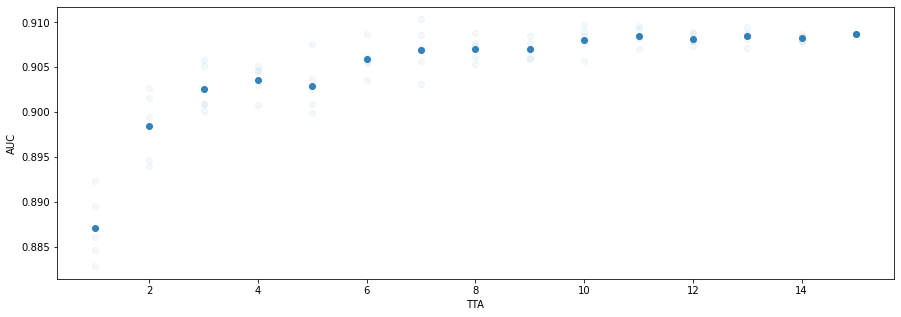

In [19]:
### 测试不同TTA个数情况下，效果的提升情况
### 结论，当TTA为15的时候，比较好
R = 5
df = df_oof.merge(df_base_train[['image_name', 'patient_id', 'target']], on='image_name').merge(testiness, on='image_name')
plt.figure(figsize=(15, 5))
for N in range(1, TTA + 1):
    aucs = []; caucs = []
    for r in range(R):
        df_i = df.sample(frac=1.0).groupby('image_name').tail(N).groupby('image_name').mean().reset_index()
        aucs.append(metrics.roc_auc_score(df_i.target, df_i.pred))
        caucs.append(metrics.roc_auc_score(df_i.target, df_i.pred, sample_weight=df_i.testiness))
    plt.scatter([N] * R, aucs, color='tab:blue', alpha=0.05)
    plt.scatter(N, sum(aucs) / R, color='tab:blue', alpha=0.9)
plt.xlabel("TTA"); plt.ylabel("AUC");

In [20]:
xxx = df_oof.groupby('image_name').mean().reset_index().merge(df_base_train, on='image_name')
print("OOF AUC (TTA %d) = %.4f" % (TTA, metrics.roc_auc_score(xxx.target, xxx.pred)))

OOF AUC (TTA 15) = 0.9087


## 8.保存结果

In [21]:
df_res.to_csv('../working/test_res_all.csv', index=False)
df_oof.to_csv('../working/oof_res_all.csv', index=False)

In [22]:
df_res[['image_name', 'pred']].groupby('image_name').mean().reset_index().rename({'pred': 'target'}, axis=1).to_csv("submission.csv", index=False)